# Dilated CNN
Notebook for final predictions for February 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import os

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import tensorflow as tf
from tqdm import tqdm


from sklearn.metrics import mean_squared_error, mean_absolute_error

### Reading in Preprocessed datasets
Concatting the the preprocessed datasets. I chose a work around by deleting the date column while concatting the individual dataframes AND then at the end set the index to the sample date index.

In [2]:
# Work around for concatting muiltiple region datasets
# Read the one of the dataframe sfor the Date columns
df = pd.read_csv('data_regions/NSW_iso.csv')
merge_index = pd.to_datetime(df['Date'])

del df

In [3]:
# For loop for the 7 region datasets
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

# Instantiate a pandas dataframe with the length of the date column
merge_df = pd.DataFrame(index = range(len(merge_index)))
for each in regions:
    df = pd.read_csv('data_regions/{}_iso.csv'.format(each))
    df.drop(columns = ['Date'], inplace=True)
    # for each region concatenate
    merge_df = pd.concat([merge_df, df], axis = 1)
# Finally reset the index with Datetime
merge_df.index = merge_index
print('Before Clipping: {}'.format(merge_df.shape))
print('\n')
# Dropping values observations from 2021-01-19 to 2021-01-22
# There seems to be more missing values and I will interpolate the missing values
merge_df = merge_df['2005-01-01':'2021-01-18'].copy()

# There are 3 missing values within the temperature statistics (01-10-2021, 01-11-21, 01-17-21)
# Interpolate the missing values
merge_df.interpolate(inplace=True)
print('After Clipping: {}'.format(merge_df.shape))

Before Clipping: (5866, 63)


After Clipping: (5862, 63)


### Feature Engineering
Transform the estimated fire area to log scale and exponentiate after predicting in log scale form. <br>

Surface Area:
- Assume the fire areas are conglomerated into one pixel and the surface area would be <br>
4 * square root of the Area

- Assume the fire area pixels are separated(non touching) and the areas of each pixel are the same.<br>
The surface area would be the count of the pixels * square root of (area / count)

In [4]:
fire_regions = ['Estimated_fire_area_{}'.format(i) for i in regions]
count_regions = ['Count_{}'.format(i) for i in regions]
sqrt_fire_regions = ['sqrt_{}'.format(i) for i in fire_regions]
sqrt_count_regions = ['sqrt_Count_{}'.format(i) for i in regions]

for i,x in zip(fire_regions, count_regions):
    merge_df[i] = np.log1p(merge_df[i])
    merge_df[x] = np.log1p(merge_df[i])
    
# merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)


for i,x in zip(fire_regions, count_regions):
    merge_df['sqrt_{}'.format(i)] = np.sqrt(merge_df[i])
    merge_df['sqrt_{}'.format(x)] = np.sqrt(merge_df[i]/merge_df[x]) * merge_df[x]
    
# sqrt_count_regions has NaN when dividing by 0
merge_df.fillna(0, inplace=True)

In [5]:
# reassigning the columns so the 7 estimated fire areas are the first 7 columns of the dataframe
merge_df = pd.concat([merge_df[fire_regions], merge_df.drop(columns = fire_regions)], axis =1)
merge_df.head()

,Estimated_fire_area_NSW,Estimated_fire_area_NT,Estimated_fire_area_QL,Estimated_fire_area_SA,Estimated_fire_area_TA,Estimated_fire_area_VI,Estimated_fire_area_WA,Count_NSW,mean_Precipitation_NSW,mean_RelativeHumidity_NSW,...,sqrt_Estimated_fire_area_QL,sqrt_Count_QL,sqrt_Estimated_fire_area_SA,sqrt_Count_SA,sqrt_Estimated_fire_area_TA,sqrt_Count_TA,sqrt_Estimated_fire_area_VI,sqrt_Count_VI,sqrt_Estimated_fire_area_WA,sqrt_Count_WA
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.000000,1.782551,3.684660,0.0,0.0,0.000000,3.621203,0.000000,0.044274,36.355567,...,1.919547,2.385413,0.0,0.0,0.0,0.0,0.000000,0.000000,1.902946,2.354318
2005-01-02,0.000000,0.841567,4.181505,0.0,0.0,1.335001,5.004661,0.000000,0.173879,38.699607,...,2.044873,2.622780,0.0,0.0,0.0,0.0,1.155422,1.064001,2.237110,2.995168
2005-01-03,0.000000,4.496917,3.879223,0.0,0.0,0.693147,4.121185,0.000000,3.011912,49.365152,...,1.969574,2.479620,0.0,0.0,0.0,0.0,0.832555,0.604155,2.030070,2.594511
2005-01-04,2.270062,0.000000,3.437208,0.0,0.0,0.000000,4.470200,1.184809,2.808620,57.095628,...,1.853971,2.263079,0.0,0.0,0.0,0.0,0.000000,0.000000,2.114285,2.756135
2005-01-05,2.868538,0.000000,1.609438,0.0,0.0,0.000000,3.477508,1.352877,0.157935,47.170735,...,1.268636,1.242444,0.0,0.0,0.0,0.0,0.000000,0.000000,1.864808,2.283203


### Train test split

In [9]:
train_df = merge_df[:'2020-10-28']
# 120 days before 2019-12-01
val_df = merge_df['2020-06-30':'2020-12-08']
# 161 days(120 + 41 days) before 2021-01-18
test_df = merge_df['2020-08-11':]

### MinMax Scaler

In [10]:
scaler = MinMaxScaler()
scaler.fit(train_df)
scaled_train_df = scaler.transform(train_df)
train_df = pd.DataFrame(data = scaled_train_df,
                       index = train_df.index,
                       columns = train_df.columns)

scaled_val_df = scaler.transform(val_df)
val_df = pd.DataFrame(data = scaled_val_df,
                       index = val_df.index,
                       columns = val_df.columns)

scaled_test_df = scaler.transform(test_df)
test_df = pd.DataFrame(data = scaled_test_df,
                       index = test_df.index,
                       columns = test_df.columns)

### Window Generator
tutorial is found here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [26]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df = train_df, val_df = val_df, test_df = test_df,
                label_columns = None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    
    def plot(self, model=None, plot_col='Estimated_fire_area_NSW', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns is not None:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [days]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                                  targets=None,
                                                                  sequence_length=self.total_window_size,
                                                                  sequence_stride=1,
                                                                  shuffle=False,
                                                                  batch_size=32,)
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            
            self._example = result
        return result
        

In [27]:
n_steps_in, n_steps_out = 120, 41

In [28]:
w1 = WindowGenerator(input_width = n_steps_in, label_width = 41, shift = 41, label_columns = fire_regions)

In [29]:
w1

Total window size: 161
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160]
Label column name(s): ['Estimated_fire_area_NSW', 'Estimated_fire_area_NT', 'Estimated_fire_area_QL', 'Estimated_fire_area_SA', 'Estimated_fire_area_TA', 'Estimated_fire_area_VI', 'Estimated_fire_area_WA']

In [30]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                          np.array(train_df[100:100+w1.total_window_size]),
                          np.array(train_df[200:200+w1.total_window_size])])

In [31]:
example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 161, 77)
Inputs shape: (3, 120, 77)
labels shape: (3, 41, 7)


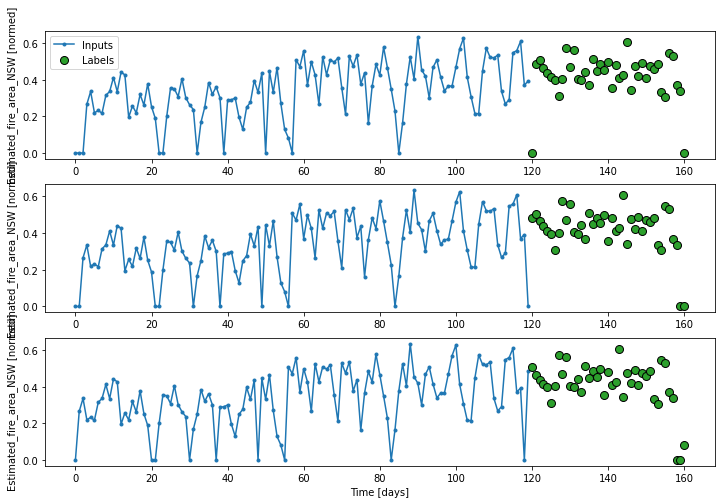

In [32]:
w1.plot()

In [41]:
def compile_and_fit(model, window, patience = 10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                     patience = patience, 
                                                     mode = 'min')
    
    model.compile(loss = tf.keras.losses.Poisson(),
                 optimizer = tf.keras.optimizers.Adam(lr = 1e-4),
                 metrics = ['mae'])
    
    history = model.fit(window.train, epochs = MAX_EPOCHS,
                       validation_data = window.val,
                       callbacks = [early_stopping])
    
    return history

In [42]:
multi_window = WindowGenerator(input_width = n_steps_in, label_width = 41, shift = 41)

### Baseline(Last)

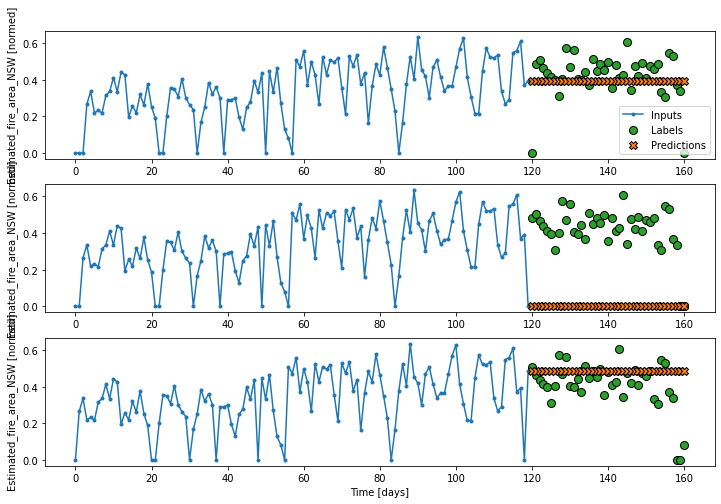

In [43]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, n_steps_out, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss = tf.keras.losses.Poisson(),
                     metrics = ['mae'])

multi_window.plot(last_baseline)

In [44]:
multi_performance = {}
# predict 2020-12-08:2021-01-18 (one matrix)
baseline_pred = last_baseline.predict(multi_window.test)
# inverse transform and slice only fire regions
baseline_pred_region = scaler.inverse_transform(np.reshape(baseline_pred, (41, 77)))[:, :7]
# exponentiate minus 1
baseline_pred_region = np.exp(baseline_pred_region) - 1

# inverse transform actual 2020-12-08:2020-01-18(fire regions only)
test_actual = scaler.inverse_transform(test_df[-41:])[:, :7]
# exponentiate minus 1
test_actual = np.exp(test_actual) - 1

In [45]:
# (MAE, RMSE) as metrics
multi_performance['Last'] = (mean_absolute_error(test_actual.flatten(),
                                               baseline_pred_region.flatten()),
                            np.sqrt(mean_squared_error(test_actual.flatten(),
                                     baseline_pred_region.flatten())))

In [46]:
multi_performance

{'Last': (66.09734571444454, 146.3887187544383)}

### DCNN Slingshot

In [47]:
# DCNN architecture taken from Joseph Eddy
# https://github.com/JEddy92/TimeSeries_Seq2Seq
n_features = 77
n_output = 77 * 41
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)]

tf.keras.backend.clear_session()
history_seq = tf.keras.layers.Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = tf.keras.layers.Conv1D(16, 1, activation='relu')(x) 
    
    # filter convolution
    x_f = tf.keras.layers.Conv1D(filters=n_filters,
                                kernel_size=filter_width, 
                               activation = 'tanh',
                                padding='causal',
                                dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = tf.keras.layers.Conv1D(filters=n_filters,
                                 kernel_size=filter_width, 
                                 activation = 'sigmoid',
                                 padding='causal',
                                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = tf.keras.layers.Multiply()([x_f, x_g])
    
    # postprocessing - equivalent to time-distributed dense
    z = tf.keras.layers.Conv1D(16, 1, activation='relu')(z)

    
    # residual connection
    x = tf.keras.layers.Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = tf.keras.layers.Add()(skips)
out = tf.keras.layers.Activation('relu')(out)

# final time-distributed dense layers 
out = tf.keras.layers.Conv1D(128, 1, activation = 'relu')(out)
out = tf.keras.layers.Dropout(.2)(out)
out = tf.keras.layers.Conv1D(1, 1,)(out)
out = tf.keras.layers.Flatten()(out)
pred_seq_train = tf.keras.layers.Dense(n_output, activation = 'relu')(out)
pred_seq_train = tf.keras.layers.Reshape([n_steps_out, n_features])(pred_seq_train)

model = tf.keras.Model(history_seq, pred_seq_train)

optimizer = tf.keras.optimizers.Adam(lr = 1e-4)

model.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])

multi_conv_sling = tf.keras.Model(history_seq, pred_seq_train)


In [48]:
MAX_EPOCHS = 100
history = compile_and_fit(multi_conv_sling, multi_window)

Epoch 1/100
176/176 [==============================] - 8s 47ms/step - loss: 1.5893 - mae: 0.2632 - val_loss: 1.1662 - val_mae: 0.2151
Epoch 2/100
176/176 [==============================] - 7s 42ms/step - loss: 1.1540 - mae: 0.1991 - val_loss: 1.1342 - val_mae: 0.1933
Epoch 3/100
176/176 [==============================] - 7s 41ms/step - loss: 1.1428 - mae: 0.1917 - val_loss: 1.1287 - val_mae: 0.1872
Epoch 4/100
176/176 [==============================] - 7s 42ms/step - loss: 1.1394 - mae: 0.1886 - val_loss: 1.1271 - val_mae: 0.1847
Epoch 5/100
176/176 [==============================] - 7s 41ms/step - loss: 1.1381 - mae: 0.1871 - val_loss: 1.1261 - val_mae: 0.1832
Epoch 6/100
176/176 [==============================] - 7s 41ms/step - loss: 1.1370 - mae: 0.1858 - val_loss: 1.1253 - val_mae: 0.1816
Epoch 7/100
176/176 [==============================] - 7s 42ms/step - loss: 1.1359 - mae: 0.1846 - val_loss: 1.1242 - val_mae: 0.1801
Epoch 8/100
176/176 [==============================] - 7s 41ms

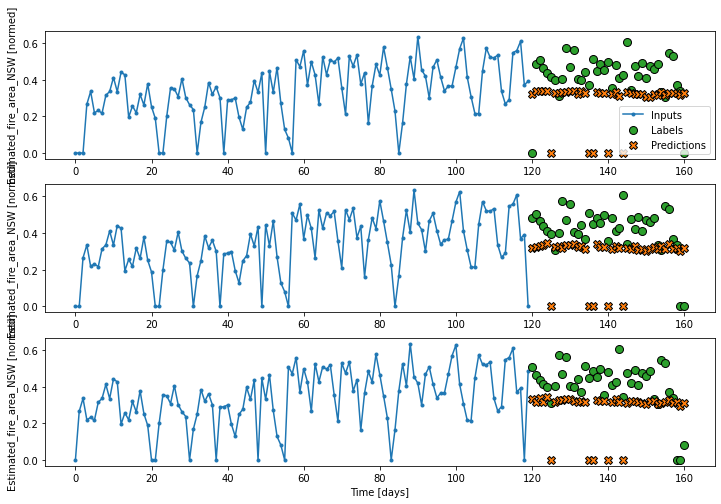

In [49]:
multi_window.plot(multi_conv_sling)

In [50]:
# predict 2020-12-08:2021-01-18 (one matrix)
conv_sling_pred = multi_conv_sling.predict(multi_window.test)
# inverse transform and slice only fire regions
conv_sling_pred_region = scaler.inverse_transform(np.reshape(conv_sling_pred, (41, 77)))[:, :7]
# exponentiate minus 1
conv_sling_pred_region = np.exp(conv_sling_pred_region) - 1


In [51]:

multi_performance['conv_sling'] = (mean_absolute_error(test_actual.flatten(),
                                                       conv_sling_pred_region.flatten()),
                                   np.sqrt(mean_squared_error(test_actual.flatten(),
                                                              conv_sling_pred_region.flatten())))
multi_performance

{'Last': (66.09734571444454, 146.3887187544383),
 'conv_sling': (21.358864208994873, 38.510730674620476)}

In [52]:
single_window = WindowGenerator(input_width = 120, label_width = 1, shift = 1)
single_window

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]
Label column name(s): None

In [53]:
n_steps_in

120

In [54]:
# DCNN architecture taken from Joseph Eddy
# https://github.com/JEddy92/TimeSeries_Seq2Seq
n_features = 77
n_output = 77 * 41
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(8)]

tf.keras.backend.clear_session()
history_seq = tf.keras.layers.Input(shape =(n_steps_in, n_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = tf.keras.layers.Conv1D(16, 1, activation='relu')(x) 
    
    # filter convolution
    x_f = tf.keras.layers.Conv1D(filters=n_filters,
                                kernel_size=filter_width, 
                               activation = 'tanh',
                                padding='causal',
                                dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = tf.keras.layers.Conv1D(filters=n_filters,
                                 kernel_size=filter_width, 
                                 activation = 'sigmoid',
                                 padding='causal',
                                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = tf.keras.layers.Multiply()([x_f, x_g])
    
    # postprocessing - equivalent to time-distributed dense
    z = tf.keras.layers.Conv1D(16, 1, activation='relu')(z)

    
    # residual connection
    x = tf.keras.layers.Add()([x, z])    


    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = tf.keras.layers.Add()(skips)
out = tf.keras.layers.Activation('relu')(out)

# final time-distributed dense layers 
out = tf.keras.layers.Conv1D(128, 1, activation = 'relu')(out)
out = tf.keras.layers.Dropout(.2)(out)
out = tf.keras.layers.Conv1D(1, 1,)(out)
out = tf.keras.layers.Flatten()(out)
pred_seq_train = tf.keras.layers.Dense(n_features, activation = 'relu')(out)
# pred_seq_train = tf.keras.layers.Reshape([n_steps_out, n_features])(pred_seq_train)


multi_conv_single = tf.keras.Model(history_seq, pred_seq_train)

# optimizer = tf.keras.optimizers.Adam(lr = 1e-4)

# multi_conv_single.compile(optimizer, loss= tf.keras.losses.Poisson(), metrics = ['mae'])




In [55]:
history = compile_and_fit(multi_conv_single, single_window)

Epoch 1/100
177/177 [==============================] - 9s 54ms/step - loss: 2.9650 - mae: 0.3280 - val_loss: 2.3585 - val_mae: 0.3190
Epoch 2/100
177/177 [==============================] - 7s 41ms/step - loss: 1.7842 - mae: 0.2679 - val_loss: 1.5688 - val_mae: 0.2704
Epoch 3/100
177/177 [==============================] - 7s 42ms/step - loss: 1.3308 - mae: 0.2340 - val_loss: 1.3943 - val_mae: 0.2384
Epoch 4/100
177/177 [==============================] - 7s 41ms/step - loss: 1.2255 - mae: 0.2205 - val_loss: 1.2117 - val_mae: 0.2265
Epoch 5/100
177/177 [==============================] - 7s 41ms/step - loss: 1.1177 - mae: 0.2135 - val_loss: 1.1891 - val_mae: 0.2170
Epoch 6/100
177/177 [==============================] - 7s 41ms/step - loss: 1.0721 - mae: 0.2068 - val_loss: 1.1776 - val_mae: 0.2071
Epoch 7/100
177/177 [==============================] - 7s 41ms/step - loss: 1.0606 - mae: 0.2017 - val_loss: 1.1737 - val_mae: 0.2023
Epoch 8/100
177/177 [==============================] - 7s 41ms

In [56]:
running_seq = test_df[:120].values
prediction = []
for _ in range(n_steps_out):
    pred = multi_conv_single.predict(running_seq.reshape((1, 120, 77)))
    prediction.append(pred)
    running_seq = np.append(running_seq,
                           pred, axis = 0)
    running_seq = np.delete(arr = running_seq,
                           obj = 0,
                           axis = 0)

In [57]:
conv_single_pred = np.array(prediction).reshape(41, 77)

conv_single_pred_region = scaler.inverse_transform(conv_single_pred)[:, :7]

conv_single_pred_region = np.exp(conv_single_pred_region) - 1

In [58]:
multi_performance['conv_single_ar'] = (mean_absolute_error(test_actual.flatten(),
                                                       conv_single_pred_region.flatten()),
                                   np.sqrt(mean_squared_error(test_actual.flatten(),
                                                              conv_single_pred_region.flatten())))
multi_performance

{'Last': (66.09734571444454, 146.3887187544383),
 'conv_sling': (21.358864208994873, 38.510730674620476),
 'conv_single_ar': (20.048098067078143, 36.278040977265256)}

In [69]:
conv_single_df = pd.DataFrame(conv_single_pred_region,
            index = test_df[-41:].index,
            columns = fire_regions)

In [70]:
match_test = pd.DataFrame(np.exp(scaler.inverse_transform(test_df[-41:])[-41:, :7]) - 1,
                          index = test_df[-41:].index,
                          columns = fire_regions)


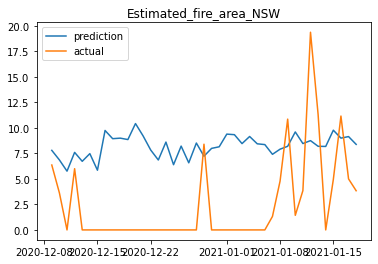

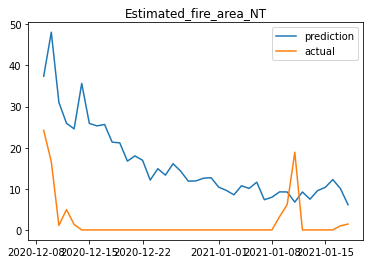

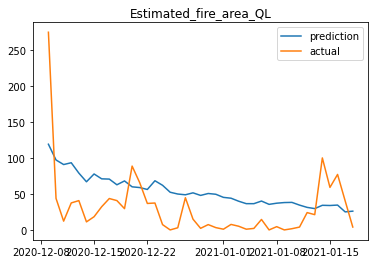

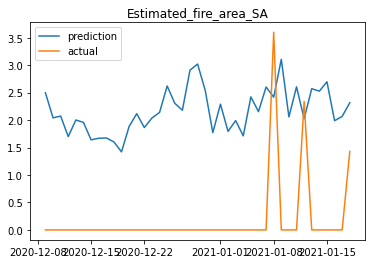

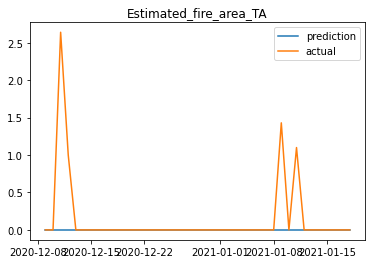

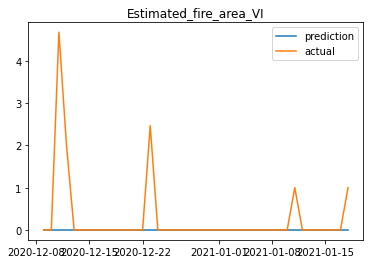

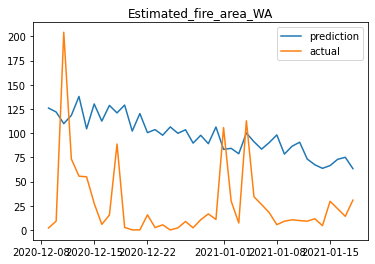

In [74]:
for i in fire_regions:
    plt.plot(conv_single_df[i], label = 'prediction')
    plt.plot(match_test[i], label = 'actual')
    plt.legend()
    plt.title(i)
    plt.show();